# Custom CNN for HER2 IHC Image Classification
## Info
### Version: V2.1.0
#### Changes:
Updated Dataset!

In [1]:
# Version information
version_info = """
Project Version: 2.1.0
Release Date: 2025-01-15
Author: Saky
"""

In [2]:
# Write to version.txt
with open("/kaggle/working/version.txt", "w") as f:
    f.write(version_info)

# Check the content by reading it back
with open("/kaggle/working/version.txt", "r") as f:
    print(f.read())


Project Version: 2.1.0
Release Date: 2025-01-15
Author: Saky



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import shap
from keras.preprocessing import image
import tensorflow.keras.backend as K

In [4]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is enabled!")
else:
    print("GPU is not enabled.")

GPU is enabled!


In [5]:
# Path to your dataset
train_dir = "/kaggle/input/her2-breast-cancer-detection-dataset/train/train"
test_dir = "/kaggle/input/her2-breast-cancer-detection-dataset/test/test"

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,               # Normalize pixel values
    rotation_range=40,               # Random rotations
    width_shift_range=0.2,           # Random horizontal shifts
    height_shift_range=0.2,          # Random vertical shifts
    shear_range=0.2,                 # Random shear
    zoom_range=0.2,                  # Random zoom
    horizontal_flip=True,            # Random horizontal flip
    fill_mode='nearest'              # Fill missing pixels
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',        # Use categorical for multi-class classification
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',        # Use categorical for multi-class classification
    shuffle=False
)


Found 8797 images belonging to 4 classes.
Found 2200 images belonging to 4 classes.


In [6]:
def build_custom_cnn(input_shape=(224, 224, 3)):
    model = models.Sequential()
    
    # Convolutional Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Flatten and Dense Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer to reduce overfitting
    model.add(layers.Dense(4, activation='softmax'))  # 4 classes for multi-class classification
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build and summarize the model
model = build_custom_cnn()
model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,265,348 (73.49 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

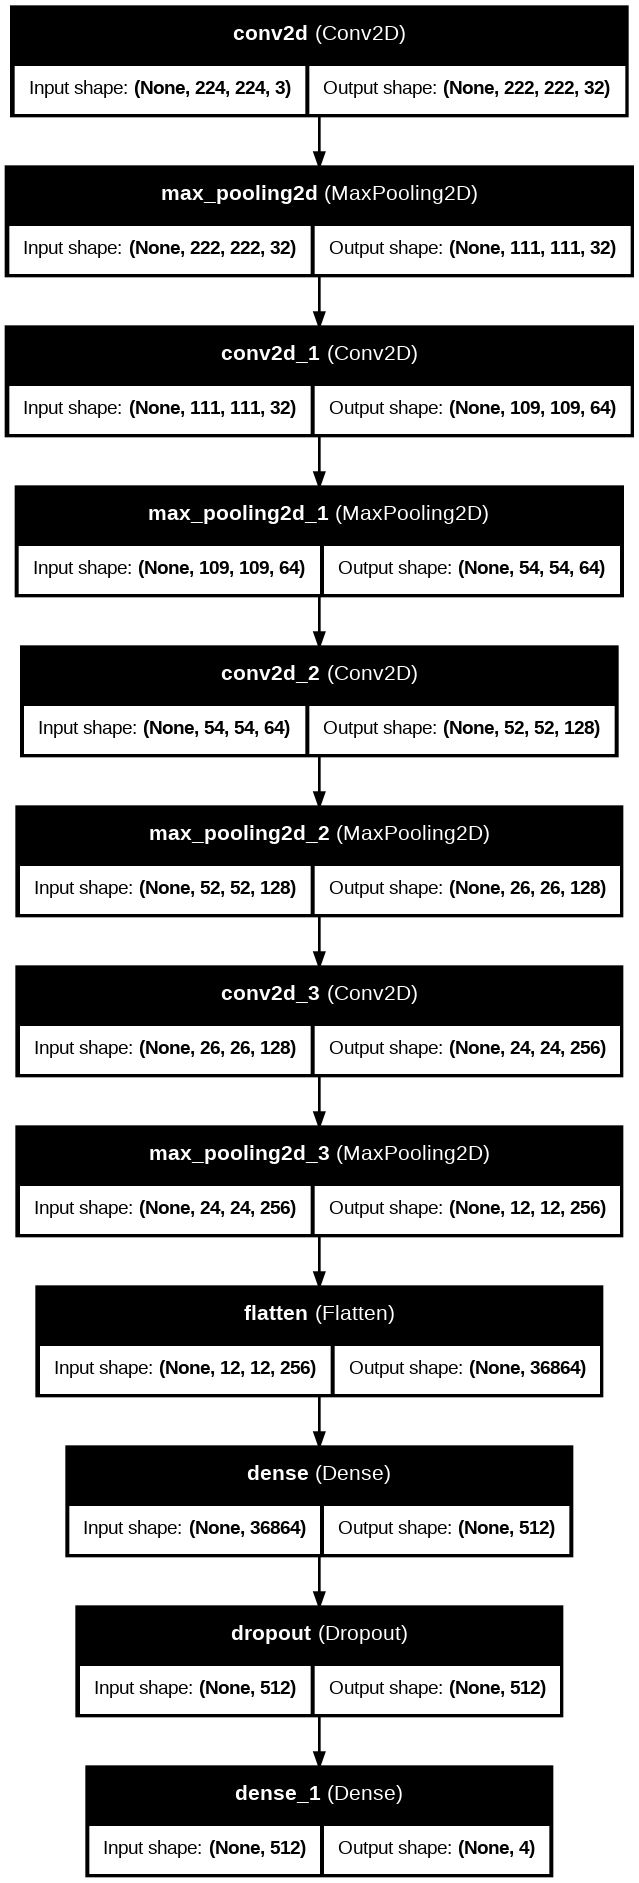

In [7]:
from tensorflow.keras.utils import plot_model

# Save the model diagram as an image file
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,  # Show input/output shapes of each layer
    show_layer_names=True,  # Show layer names
    dpi=96  # Adjust DPI for better quality
)

# If you're using a notebook, you can display the image directly
from IPython.display import Image
Image('model_architecture.png')

In [8]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Adjust epochs based on dataset size and performance
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/50


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


274/274 ━━━━━━━━━━━━━━━━━━━━ 194s 666ms/step - accuracy: 0.6231 - loss: 0.8521 - val_accuracy: 0.8479 - val_loss: 0.3966
Epoch 2/50
  1/274 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8438 - loss: 0.3657

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8438 - loss: 0.3657 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 501ms/step - accuracy: 0.8371 - loss: 0.3966 - val_accuracy: 0.8162 - val_loss: 0.4506
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.6875 - loss: 0.5854 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 141s 504ms/step - accuracy: 0.8442 - loss: 0.3769 - val_accuracy: 0.8833 - val_loss: 0.2805
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.8125 - loss: 0.4374 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 498ms/step - accuracy: 0.8692 - loss: 0.3255 - val_accuracy: 0.8162 - val_loss: 0.4145
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.8125 - loss: 0.4870 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 142s 508ms/step - accuracy: 0.8587 - loss

In [9]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc*100:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.9011 - loss: 0.2551
Test accuracy: 90.12%


# Prediction and Generating Reports

In [10]:
# Generate predictions for the validation or test set
predictions = model.predict(test_generator)  # Ensure you use the correct generator
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve true labels from the generator
true_classes = test_generator.classes  # Ensure you use the same generator as in the prediction step

# Check the number of samples in true and predicted classes
print(f"Number of true labels: {len(true_classes)}")
print(f"Number of predicted labels: {len(predicted_classes)}")

# Ensure the lengths match
if len(true_classes) != len(predicted_classes):
    raise ValueError("Mismatch in number of true and predicted samples. Check the generator settings.")

# Get the class indices to use target names in the report
target_names = list(test_generator.class_indices.keys())

# Generate the classification report
from sklearn.metrics import classification_report
print(classification_report(true_classes, predicted_classes, target_names=target_names))

69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step
Number of true labels: 2200
Number of predicted labels: 2200
              precision    recall  f1-score   support

     class_0       0.92      0.93      0.93       758
    class_1+       0.88      0.72      0.79       538
    class_2+       0.70      0.96      0.81       226
    class_3+       1.00      0.99      0.99       678

    accuracy                           0.90      2200
   macro avg       0.87      0.90      0.88      2200
weighted avg       0.91      0.90      0.90      2200



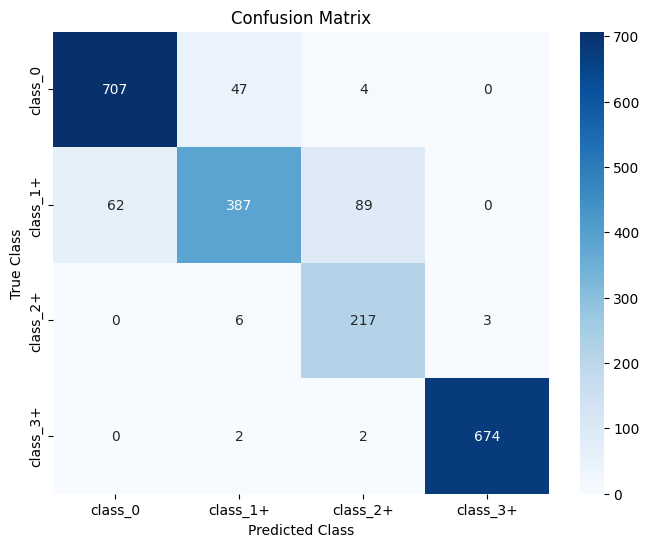

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

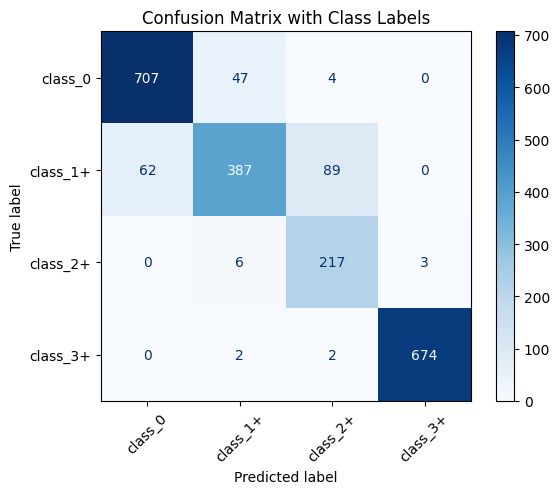

In [12]:
# Optional: Use sklearn's built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix with Class Labels")
plt.show()

In [13]:
# Specify the path where you want to save the model
model_save_path = "/kaggle/working/custom_cnn_model_updated.h5"  # Use .h5 for HDF5 format or .tf for TensorFlow SavedModel format

# Save the trained model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/custom_cnn_model_updated.h5


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,796,046 (220.47 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,530,698 (146.98 MB)

In [15]:
for layer in model.layers:
    print(layer.name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
flatten
dense
dropout
dense_1


In [16]:
print(model.input_shape)  # Expected input shape for the model

(None, 224, 224, 3)


In [18]:
model.save("latest.h5")

## Explanable AI with Lime

In [26]:
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# ✅ Load the trained model
model = tf.keras.models.load_model("/kaggle/working/custom_cnn_model_updated.h5")  # Change this to your model path
model.summary()

# ✅ Function to preprocess an image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# ✅ Load and preprocess the sample image
sample_image_path = "/kaggle/input/her2-breast-cancer-detection-dataset/test/test/class_0/her2-0-score_test_1167.png"
sample_image = preprocess_image(sample_image_path)

# ✅ Create a small set of background images for SHAP calculations
background = np.random.rand(10, 224, 224, 3)  # Random images for SHAP baseline

# ✅ Create DeepExplainer for CNN models
explainer = shap.DeepExplainer(model, background)

# ✅ Compute SHAP values
shap_values = explainer.shap_values(sample_image)

# ✅ Visualize SHAP explanations
shap.image_plot(shap_values, sample_image)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,265,350 (73.49 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

AttributeError: module 'tensorflow.keras.backend' has no attribute 'get_session'

In [27]:
import shap
import numpy as np

# SHAP requires a small sample from the dataset as background
background = sample_images[:50]  # Select 50 images for background

# Use GradientExplainer instead of DeepExplainer
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for a sample image
shap_values = explainer.shap_values(sample_image)

# Visualize SHAP explanations
shap.image_plot(shap_values, sample_image)

NameError: name 'sample_images' is not defined

In [1]:
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Ensure TensorFlow is using the correct version
print(f"TensorFlow Version: {tf.__version__}")

# ✅ Load a pre-trained CNN model (Replace with your model)
model = tf.keras.models.load_model("/kaggle/input/latest-model/other/default/1/latest.h5")

# ✅ Load and preprocess an input image (Replace with your dataset)
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))  # Resize to model's expected input
    img = img / 255.0  # Normalize
    return np.expand_dims(img, axis=0)  # Add batch dimension

image_path = "/kaggle/input/her2-breast-cancer-detection-dataset/train/train/class_0/her2-0-score_test_1169.png"  # Replace with your image path
input_image = preprocess_image(image_path)

# ✅ Background data for SHAP (Use representative samples)
background_data = np.random.rand(10, 224, 224, 3)  # Random dataset as background

# ✅ Use shap.GradientExplainer (compatible with TensorFlow 2.x)
explainer = shap.GradientExplainer(model, background_data)

# ✅ Compute SHAP values
shap_values = explainer.shap_values(input_image)

# ✅ Plot SHAP Explanation
shap.image_plot(shap_values, input_image)

TensorFlow Version: 2.17.1


AttributeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/shap/explainers/_gradient.py", line 217, in grad_graph  *
        phase = tf.keras.backend.learning_phase()

    AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'learning_phase'


---

# SHAP

TensorFlow Version: 2.17.1


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.96s/it]               


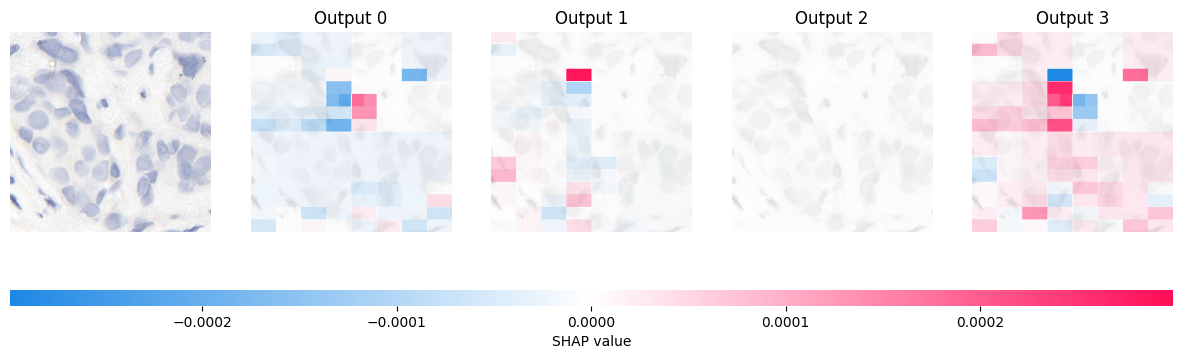

In [5]:
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# ✅ Ensure TensorFlow is using the correct version
print(f"TensorFlow Version: {tf.__version__}")

# ✅ Load your pre-trained CNN model
model = tf.keras.models.load_model("/kaggle/input/latest-model/other/default/1/latest.h5")

# ✅ Load and preprocess an input image
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))  # Resize to model's expected input
    img = img / 255.0  # Normalize
    return np.expand_dims(img, axis=0)  # Add batch dimension

image_path = "/kaggle/input/her2-breast-cancer-detection-dataset/train/train/class_0/her2-0-score_test_1169.png"
input_image = preprocess_image(image_path)

# ✅ Use SHAP's Image Masker
masker = shap.maskers.Image("inpaint_telea", input_image[0].shape)

# ✅ Use `shap.Explainer` with the masker
explainer = shap.Explainer(model, masker)

# ✅ Compute SHAP values
shap_values = explainer(input_image)

# ✅ Plot SHAP Explanation
shap.image_plot(shap_values)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.35s/it]               


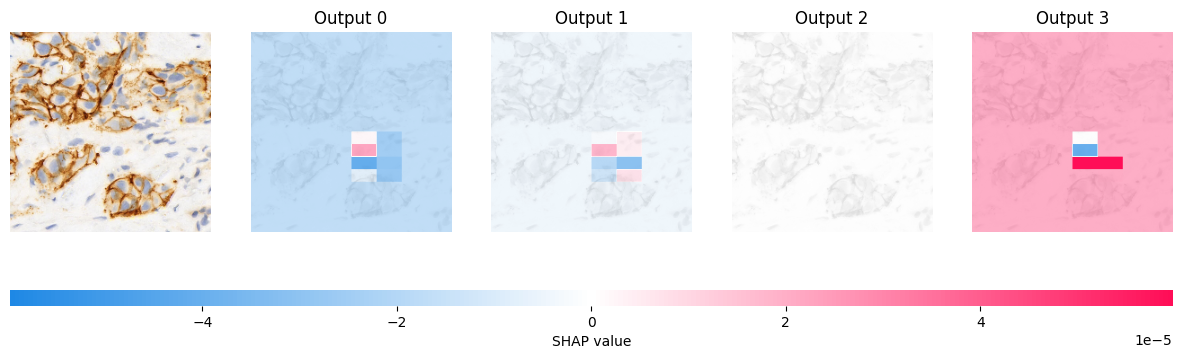

In [6]:
image_path = "/kaggle/input/her2-breast-cancer-detection-dataset/train/train/class_3+/her2-1+-score_test_11.png"
input_image = preprocess_image(image_path)

# ✅ Use SHAP's Image Masker
masker = shap.maskers.Image("inpaint_telea", input_image[0].shape)

# ✅ Use `shap.Explainer` with the masker
explainer = shap.Explainer(model, masker)

# ✅ Compute SHAP values
shap_values = explainer(input_image)

# ✅ Plot SHAP Explanation
shap.image_plot(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.17s/it]               


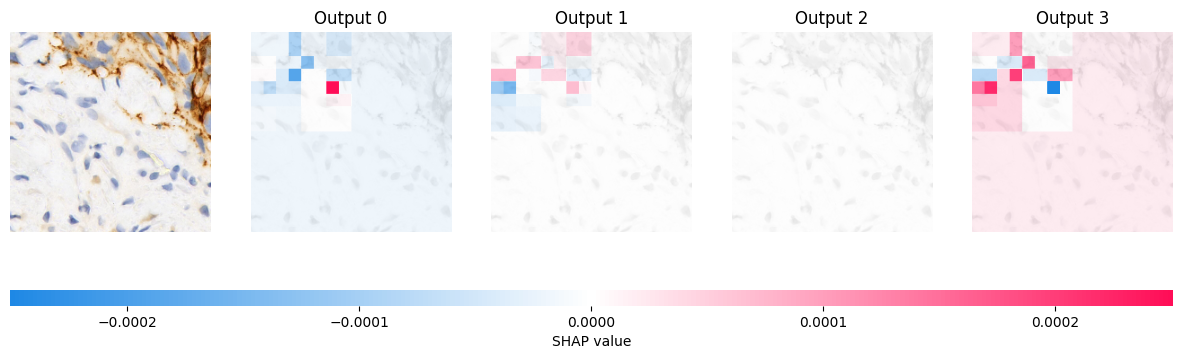

In [19]:
image_path = "/kaggle/input/her2-breast-cancer-detection-dataset/train/train/class_3+/her2-1+-score_train_02.png"
input_image = preprocess_image(image_path)

# ✅ Use SHAP's Image Masker
masker = shap.maskers.Image("inpaint_telea", input_image[0].shape)

# ✅ Use `shap.Explainer` with the masker
explainer = shap.Explainer(model, masker)

# ✅ Compute SHAP values
shap_values = explainer(input_image)

# ✅ Plot SHAP Explanation
shap.image_plot(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.51s/it]               


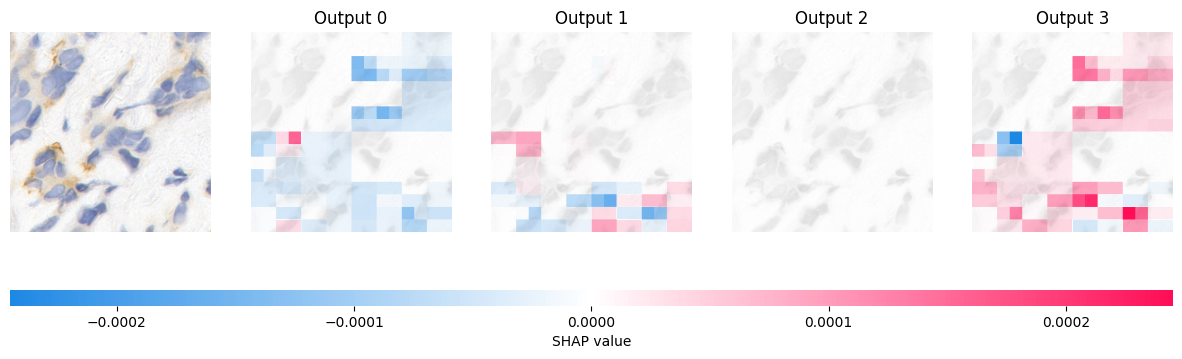

In [27]:
image_path = "/kaggle/input/her2-breast-cancer-detection-dataset/train/train/class_1+/her2-0-score_test_1324.png"
input_image = preprocess_image(image_path)

# ✅ Use SHAP's Image Masker
masker = shap.maskers.Image("inpaint_telea", input_image[0].shape)

# ✅ Use `shap.Explainer` with the masker
explainer = shap.Explainer(model, masker)

# ✅ Compute SHAP values
shap_values = explainer(input_image)

# ✅ Plot SHAP Explanation
shap.image_plot(shap_values)